In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats
from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# import csv file
ev_df = pd.read_csv('data/Cleaned data/ev_df_copy.csv')

# Create a datetime index based on 'Year' and 'Quarter' columns
ev_df['Date'] = pd.to_datetime(ev_df['Year'].astype(str) + 'Q' + ev_df['Quarter'].astype(str))

# Read in ev_sentiment_df
ev_sentiment_df = pd.read_csv('data/ev_sentiment_df.csv')
ev_sentiment_df['ds'] = pd.to_datetime(ev_sentiment_df['ds'])

# Create dictionary of sentiment scores for each ds
sentiment_dict = dict(zip(ev_sentiment_df['ds'], ev_sentiment_df['yhat']))

# Create new column in ev_df for sentiment scores
ev_df['Sentiment'] = ev_df['Date'].map(sentiment_dict)
ev_df.set_index('Date', inplace=True)

# split into train/test datasets
train_df = ev_df[:'2019-03-31']
test_df = ev_df['2019-04-01':]


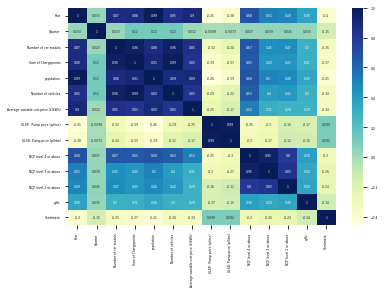

In [14]:
# correlation heatmap for ev_df
corr = ev_df.corr()
sns.heatmap(corr, cmap="YlGnBu", annot=True)
# make text in heatmap smaller
plt.rcParams['font.size'] = 3
plt.show()

In [4]:
ev_df.shape

(500, 15)

In [5]:
ev_df.columns

Index(['Year', 'Quarter', 'ITL level 1', 'Number of car models',
       'Sum of Chargepoints', 'population', 'Number of vehicles',
       'Average variable unit price (£/kWh)', 'ULSP:  Pump price (p/litre)',
       'ULSD: Pump price (p/litre)', 'NQF level 4 or above',
       'NQF level 3 or above', 'NQF level 2 or above', 'gdhi', 'Sentiment'],
      dtype='object')

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This p

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02316D+02    |proj g|=  2.26146D+03

At iterate    5    f=  1.28804D+01    |proj g|=  1.90064D+00

At iterate   10    f=  1.16632D+01    |proj g|=  1.90880D-01

At iterate   15    f=  1.15395D+01    |proj g|=  2.75256D-02

At iterate   20    f=  1.15173D+01    |proj g|=  6.62535D-03

At iterate   25    f=  1.15155D+01    |proj g|=  6.04614D-04

At iterate   30    f=  1.15136D+01    |proj g|=  4.76378D-03

At iterate   35    f=  1.15135D+01    |proj g|=  1.47394D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate   10    f=  1.13243D+01    |proj g|=  1.54538D-02

At iterate   15    f=  1.12469D+01    |proj g|=  2.04029D-03

At iterate   20    f=  1.12421D+01    |proj g|=  7.87207D-03
  ys=-9.736E-06  -gs= 9.965E-06 BFGS update SKIPPED

At iterate   25    f=  1.12414D+01    |proj g|=  2.32177D-04

At iterate   30    f=  1.12412D+01    |proj g|=  2.25110D-03

At iterate   35    f=  1.12411D+01    |proj g|=  6.66067D-04

At iterate   40    f=  1.12411D+01    |proj g|=  5.54875D-04

At iterate   45    f=  1.12410D+01    |proj g|=  2.62870D-03

At iterate   50    f=  1.12410D+01    |proj g|=  4.10113D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is uncon


At iterate    5    f=  1.19488D+01    |proj g|=  8.05887D-01

At iterate   10    f=  1.17217D+01    |proj g|=  2.31417D-01

At iterate   15    f=  1.15381D+01    |proj g|=  7.49529D-02

At iterate   20    f=  1.12557D+01    |proj g|=  8.31340D-01

At iterate   25    f=  1.12331D+01    |proj g|=  1.02504D-03

At iterate   30    f=  1.12329D+01    |proj g|=  5.92343D-02

At iterate   35    f=  1.12320D+01    |proj g|=  7.70200D-02

At iterate   40    f=  1.12318D+01    |proj g|=  5.45740D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43     65      1     0     0   9.060D-04   1.123D+01
  F =   11.2318424836

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.15410D+01    |proj g|=  1.45071D-02

At iterate   15    f=  1.15390D+01    |proj g|=  1.40402D-01

At iterate   20    f=  1.13522D+01    |proj g|=  1.01283D+00

At iterate   25    f=  1.12982D+01    |proj g|=  4.56767D-01

At iterate   30    f=  1.12956D+01    |proj g|=  4.72943D-04

At iterate   35    f=  1.12952D+01    |proj g|=  2.12525D-03

At iterate   40    f=  1.12952D+01    |proj g|=  1.86274D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     40     50      1     0     0   1.863D-04   1.130D+01
  F =   11.295180914125998     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  1.15992D+01    |proj g|=  1.30365D-01

At iterate   20    f=  1.14659D+01    |proj g|=  3.05698D-02

At iterate   25    f=  1.14294D+01    |proj g|=  5.85799D-01

At iterate   30    f=  1.14181D+01    |proj g|=  2.26075D-03

At iterate   35    f=  1.14180D+01    |proj g|=  2.09480D-02

At iterate   40    f=  1.14167D+01    |proj g|=  1.91611D-01

At iterate   45    f=  1.14154D+01    |proj g|=  6.16192D-03

At iterate   50    f=  1.14154D+01    |proj g|=  1.65577D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     57      1     0     0   1.656D-04   1.142D+01
  F =   11.4154026961

/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is uncon


At iterate   10    f=  1.18239D+01    |proj g|=  1.01958D+00

At iterate   15    f=  1.17526D+01    |proj g|=  6.09290D-01

At iterate   20    f=  1.16530D+01    |proj g|=  3.60366D+00

At iterate   25    f=  1.15640D+01    |proj g|=  1.33455D+00

At iterate   30    f=  1.15517D+01    |proj g|=  1.58753D-02

At iterate   35    f=  1.13370D+01    |proj g|=  7.41055D-01

At iterate   40    f=  1.13172D+01    |proj g|=  2.52247D-02

At iterate   45    f=  1.13128D+01    |proj g|=  2.61711D-01

At iterate   50    f=  1.12990D+01    |proj g|=  3.06509D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     65   

/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is uncon


At iterate    5    f=  1.20550D+01    |proj g|=  2.14082D+00

At iterate   10    f=  1.17253D+01    |proj g|=  5.13340D-01

At iterate   15    f=  1.16092D+01    |proj g|=  1.46818D-01

At iterate   20    f=  1.15545D+01    |proj g|=  9.83576D-02

At iterate   25    f=  1.13681D+01    |proj g|=  6.11121D-02

At iterate   30    f=  1.13650D+01    |proj g|=  2.33849D-01

At iterate   35    f=  1.13600D+01    |proj g|=  5.55794D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     35     56      1     0     0   5.558D-02   1.136D+01
  F =   11.359974602277960     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65967D+01    |proj g|=  1.29492D+01

At iterate    5    f=  1.19436D+01    |proj g|=  7.33495D-01

At iterate   10    f=  1.16054D+01    |proj g|=  3.19710D-01

At iterate   15    f=  1.15671D+01    |proj g|=  1.77527D-01

At iterate   20    f=  1.15248D+01    |proj g|=  8.83749D-02

At iterate   25    f=  1.13323D+01    |proj g|=  1.52890D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     25     43      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.



At iterate    5    f=  1.19126D+01    |proj g|=  6.16780D-01

At iterate   10    f=  1.16128D+01    |proj g|=  6.43566D-01

At iterate   15    f=  1.15756D+01    |proj g|=  3.39638D-01

At iterate   20    f=  1.15404D+01    |proj g|=  7.17747D-02

At iterate   25    f=  1.14990D+01    |proj g|=  2.91355D+00

At iterate   30    f=  1.13309D+01    |proj g|=  3.09888D-02

At iterate   35    f=  1.13235D+01    |proj g|=  5.71513D-02

At iterate   40    f=  1.13187D+01    |proj g|=  2.31044D-02

At iterate   45    f=  1.13184D+01    |proj g|=  1.91089D-01


/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  1.13172D+01    |proj g|=  2.13445D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     81      1     0     0   2.134D-01   1.132D+01
  F =   11.317214313066092     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17041D+01    |proj g|=  4.00495D-01

At iterate    5    f=  1.15741D+01    |proj g|=  2.40126D-01

At iterate   10    f=  1.15564D+01    |proj g|=  1.43628D-02

At iter

/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17358D+01    |proj g|=  4.28890D-01

At iterate    5    f=  1.16211D+01    |proj g|=  9.69499D-01

At iterate   10    f=  1.15844D+01    |proj g|=  1.36882D-02

At iterate   15    f=  1.15437D+01    |proj g|=  1.78688D-01

At iterate   20    f=  1.14053D+01    |proj g|=  1.65125D+00

At iterate   25    f=  1.13587D+01    |proj g|=  5.58383D-02

At iterate   30    f=  1.13574D+01    |proj g|=  1.59603D-01

At iterate   35    f=  1.13559D+01    |proj g|=  4.67503D-03

At iterate   40    f=  1.13559D+01    |proj g|=  6.94809D-03

At iterate   45    f=  1.13553D+01    |proj g|=  1.28968D-01

At iterate   50    f=  1.13501D+01    |proj g|=  3.63394D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


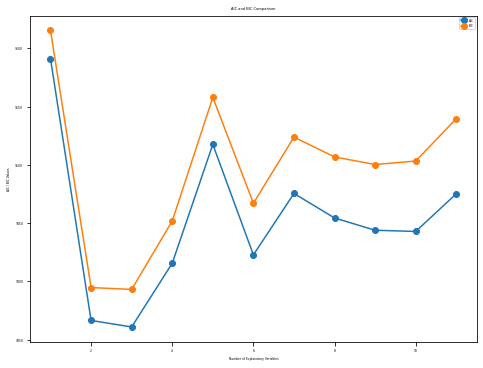

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define your dependent variable and explanatory variables
# create original_explanatory_vars list of all columns in ev_df except dependent_var, Year, Quarter 
original_explanatory_vars = list(ev_df.columns)
dependent_var = 'Number of vehicles'
explanatory_vars = [var for var in original_explanatory_vars if var not in ['Number of vehicles', 'Year', 'Quarter','ITL level 1']]

# split into train/test datasets
train_df = ev_df[:'2019-03-31']
test_df = ev_df['2019-04-01':]

# List to store AIC and BIC values for different models
aic_values = []
bic_values = []

# Fit and compare SARIMAX models with different numbers of explanatory variables
for i in range(1, len(explanatory_vars) + 1):
    current_exog = train_df[explanatory_vars[:i]]
    sarimax_model = SARIMAX(train_df[dependent_var], exog=current_exog, order=(1, 0, 1), seasonal_order=(1, 0, 1, 4))
    sarimax_result = sarimax_model.fit()
    aic_values.append(sarimax_result.aic)
    bic_values.append(sarimax_result.bic)

# Plot the AIC and BIC values for different models
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explanatory_vars) + 1), aic_values, label='AIC', marker='o')
plt.plot(range(1, len(explanatory_vars) + 1), bic_values, label='BIC', marker='o')
plt.xlabel('Number of Explanatory Variables')
plt.ylabel('AIC / BIC Values')
plt.title('AIC and BIC Comparison')
plt.legend()
plt.show()


/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70271D+01    |proj g|=  4.06930D+01

At iterate    5    f=  1.19038D+01    |proj g|=  8.43054D-01

At iterate   10    f=  1.16872D+01    |proj g|=  4.34688D-01

At iterate   15    f=  1.14806D+01    |proj g|=  6.68887D-02

At iterate   20    f=  1.14428D+01    |proj g|=  2.81081D-02

At iterate   25    f=  1.12821D+01    |proj g|=  2.91167D-01

At iterate   30    f=  1.12087D+01    |proj g|=  1.10329D-01

At iterate   35    f=  1.11980D+01    |proj g|=  9.33361D-03

At iterate   40    f=  1.11967D+01    |proj g|=  4.80083D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

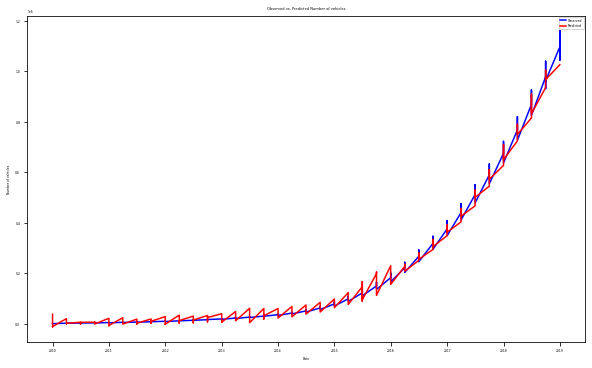

In [7]:
# Define your dependent variable and explanatory variables
dependent_var = 'Number of vehicles'
explanatory_vars = ['population', 'Average variable unit price (£/kWh)',
                    'Sum of Chargepoints']



# Fit the SARIMAX model
endog = train_df[dependent_var]
exog = train_df[explanatory_vars]
sarimax_model_3_1 = SARIMAX(endog, exog=exog, order=(1, 0, 1), seasonal_order=(1, 0, 1, 4))
sarimax_result_3_1 = sarimax_model_3_1.fit()

# Print the summary of the SARIMAX model
print(sarimax_result_3_1.summary())


# Get the predicted values from the SARIMAX model
predicted_values_3_1 = sarimax_result_3_1.predict(start=exog.index[0], end=exog.index[-1], exog=exog)

# Plot the observed and predicted values
plt.figure(figsize=(10, 6))
plt.plot(endog.index, endog, label='Observed', color='blue')
plt.plot(predicted_values_3_1.index, predicted_values_3_1, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Number of vehicles')
plt.title('Observed vs. Predicted Number of vehicles')
plt.legend()
plt.show()

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63946D+01    |proj g|=  2.66350D+01

At iterate    5    f=  1.19488D+01    |proj g|=  8.05887D-01

At iterate   10    f=  1.17217D+01    |proj g|=  2.31417D-01

At iterate   15    f=  1.15381D+01    |proj g|=  7.49533D-02

At iterate   20    f=  1.12557D+01    |proj g|=  8.31366D-01

At iterate   25    f=  1.12331D+01    |proj g|=  9.86818D-04

At iterate   30    f=  1.12329D+01    |proj g|=  7.00408D-02

At iterate   35    f=  1.12319D+01    |proj g|=  4.28829D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  1.12318D+01    |proj g|=  1.94641D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     40     74      2     0     0   1.946D-04   1.123D+01
  F =   11.231847534811035     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                     
Dep. Variable:                Number of vehicles   No. Observations:                  416
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 4)   Log Likelihood               -4672.449
Date:                           Tue, 08 Aug 2023   AIC                           9360.897
T

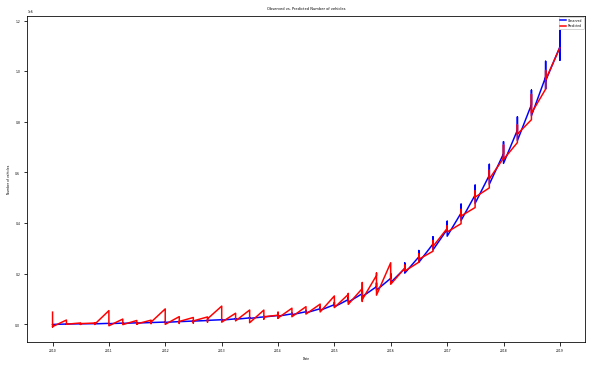

In [8]:
# Define your dependent variable and explanatory variables
dependent_var = 'Number of vehicles'
explanatory_vars = ['population', 'Number of car models',
                    'Sum of Chargepoints']


# Fit the SARIMAX model
endog = train_df[dependent_var]
exog = train_df[explanatory_vars]
sarimax_model_3_2 = SARIMAX(endog, exog=exog, order=(1, 0, 1), seasonal_order=(1, 0, 1, 4))
sarimax_result_3_2 = sarimax_model_3_2.fit()

# Print the summary of the SARIMAX model
print(sarimax_result_3_2.summary())


# Get the predicted values from the SARIMAX model
predicted_values_3_2 = sarimax_result_3_2.predict(start=exog.index[0], end=exog.index[-1], exog=exog)

# Plot the observed and predicted values
plt.figure(figsize=(10, 6))
plt.plot(endog.index, endog, label='Observed', color='blue')
plt.plot(predicted_values_3_2.index, predicted_values_3_2, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Number of vehicles')
plt.title('Observed vs. Predicted Number of vehicles')
plt.legend()
plt.show()

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17126D+01    |proj g|=  1.74179D+00

At iterate    5    f=  1.15695D+01    |proj g|=  6.77818D-02

At iterate   10    f=  1.15410D+01    |proj g|=  1.45071D-02

At iterate   15    f=  1.15390D+01    |proj g|=  1.40403D-01

At iterate   20    f=  1.13522D+01    |proj g|=  1.01261D+00

At iterate   25    f=  1.12982D+01    |proj g|=  4.56649D-01

At iterate   30    f=  1.12956D+01    |proj g|=  4.75625D-04

At iterate   35    f=  1.12952D+01    |proj g|=  3.17357D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

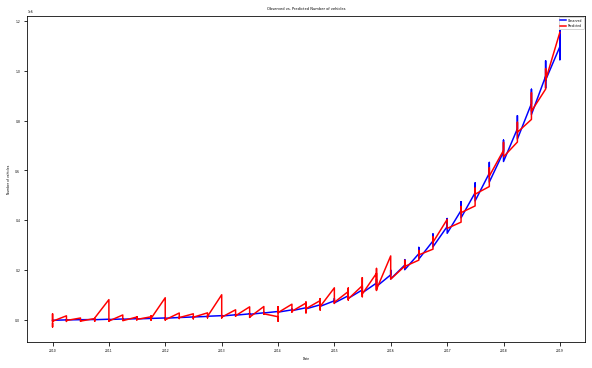

In [9]:


# Define your dependent variable and explanatory variables
dependent_var = 'Number of vehicles'
explanatory_vars = ['population', 'Average variable unit price (£/kWh)',
                    'Sum of Chargepoints', 'Number of car models']

# Fit the SARIMAX model
endog = train_df[dependent_var]
exog = train_df[explanatory_vars]
sarimax_model_4 = SARIMAX(endog, exog=exog, order=(1, 0, 1), seasonal_order=(1, 0, 1, 4))
sarimax_result_4 = sarimax_model_4.fit()

# Print the summary of the SARIMAX model
print(sarimax_result_4.summary())


# Get the predicted values from the SARIMAX model
predicted_values_4 = sarimax_result_4.predict(start=exog.index[0], end=exog.index[-1], exog=exog)

# Plot the observed and predicted values
plt.figure(figsize=(10, 6))
plt.plot(endog.index, endog, label='Observed', color='blue')
plt.plot(predicted_values_4.index, predicted_values_4, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Number of vehicles')
plt.title('Observed vs. Predicted Number of vehicles')
plt.legend()
plt.show()


Normaltest p-value: 7.605013561951048e-16


/opt/homebrew/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


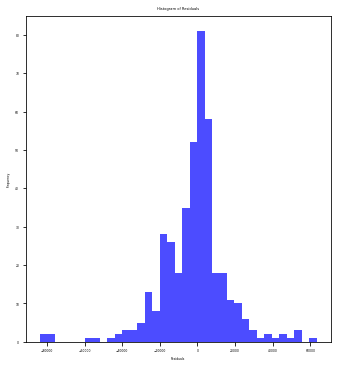

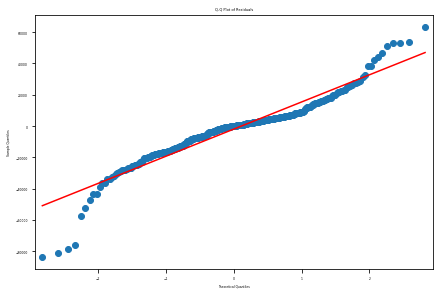

In [10]:


# Assuming 'sarimax_result' contains the fitted SARIMAX model results

# Get the residuals from the fitted model
residuals = sarimax_result_4.resid

# Shapiro-Wilk test for normality
normaltest_result = stats.normaltest(residuals)
print("Normaltest p-value:", normaltest_result.pvalue)

# Visual inspection: Histogram and Q-Q plot
plt.figure(figsize=(12, 6))

# Histogram of residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins='auto', color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

# Q-Q plot of residuals
plt.subplot(1, 2, 2)
sm.graphics.qqplot(residuals, line='s', color='blue')
plt.title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()


/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


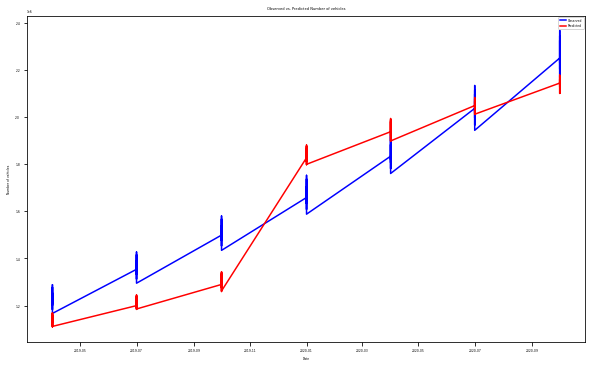

R-squared (R2 ): 0.8451896666053208
Mean Squared Error (MSE): 18731798862.5227
Root Mean Squared Error (RMSE): 136864.16208241915


In [11]:

endog_test = test_df[dependent_var]
exog_test = test_df[explanatory_vars]

predicted_values = sarimax_result_4.forecast(84, exog=test_df[explanatory_vars])
predicted_values.index = test_df.index

# Plot the observed and predicted values
plt.figure(figsize=(10, 6))
plt.plot(endog_test.index, endog_test, label='Observed', color='blue')
plt.plot(predicted_values.index, predicted_values, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Number of vehicles')
plt.title('Observed vs. Predicted Number of vehicles')
plt.legend()
plt.show()

# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
mse = mean_squared_error(endog_test, predicted_values)
rmse = np.sqrt(mse)
r2 = r2_score(endog_test, predicted_values)

print(f"R-squared (R2 ): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


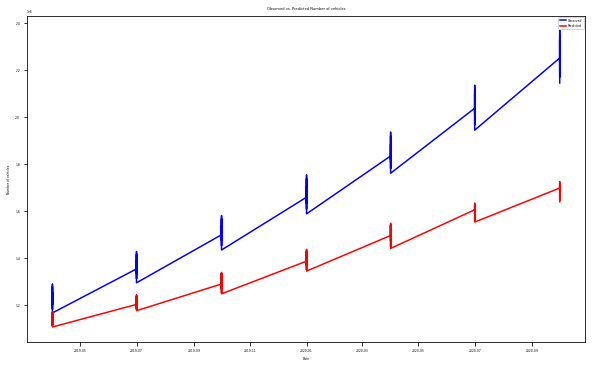

R-squared (R2 ): 0.0737178866519016
Mean Squared Error (MSE): 112078631036.55962
Root Mean Squared Error (RMSE): 334781.4675823015


In [12]:
dependent_var = 'Number of vehicles'
explanatory_vars = ['population', 'Average variable unit price (£/kWh)',
                    'Sum of Chargepoints']
                    
endog_test = test_df[dependent_var]
exog_test = test_df[explanatory_vars]

predicted_values = sarimax_result_3_1.forecast(84, exog=test_df[explanatory_vars])
predicted_values.index = test_df.index

# Plot the observed and predicted values
plt.figure(figsize=(10, 6))
plt.plot(endog_test.index, endog_test, label='Observed', color='blue')
plt.plot(predicted_values.index, predicted_values, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Number of vehicles')
plt.title('Observed vs. Predicted Number of vehicles')
plt.legend()
plt.show()

# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
mse = mean_squared_error(endog_test, predicted_values)
rmse = np.sqrt(mse)
r2 = r2_score(endog_test, predicted_values)

print(f"R-squared (R2 ): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


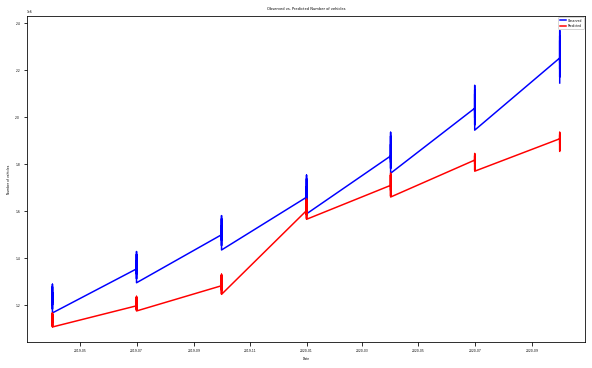

R-squared (R2 ): 0.6675259096342014
Mean Squared Error (MSE): 40228824854.054504
Root Mean Squared Error (RMSE): 200571.24632921466


In [13]:
dependent_var = 'Number of vehicles'
explanatory_vars = ['population', 'Number of car models',
                    'Sum of Chargepoints']

endog_test = test_df[dependent_var]
exog_test = test_df[explanatory_vars]

predicted_values = sarimax_result_3_2.forecast(84, exog=test_df[explanatory_vars])
predicted_values.index = test_df.index

# Plot the observed and predicted values
plt.figure(figsize=(10, 6))
plt.plot(endog_test.index, endog_test, label='Observed', color='blue')
plt.plot(predicted_values.index, predicted_values, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Number of vehicles')
plt.title('Observed vs. Predicted Number of vehicles')
plt.legend()
plt.show()

# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
mse = mean_squared_error(endog_test, predicted_values)
rmse = np.sqrt(mse)
r2 = r2_score(endog_test, predicted_values)

print(f"R-squared (R2 ): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")